In [21]:
# ---------------------------------------------
# SUPERVISED CLASSIFICATION AND CLUSTER ANALYSIS
# ---------------------------------------------

# === 1. Imports ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import umap.umap_ as umap
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


In [2]:
# === 2. Load and Prepare Data ===
input_csv = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/roi_labels_with_features.csv"
df = pd.read_csv(input_csv)

In [3]:
# Filter for labeled data
df_filtered = df[df['label'].isin(['Living', 'Non-living'])].copy()
df_filtered['label_binary'] = (df_filtered['label'] == 'Living').astype(int)

In [4]:
# === 3. Feature Extraction ===
def feature_creation(df):
    df = df.copy()
    phase_cols = [col for col in df.columns if 'fd_phase' in col]

    # Transform angular phase values
    for col in phase_cols:
        df[f'{col}_sin'] = np.sin(df[col])
        df[f'{col}_cos'] = np.cos(df[col])

    exclude_cols = ['filename', 'image_name', 'roi_index', 'label', 'minr', 'minc', 'maxr', 'maxc', 'label_binary'] + phase_cols
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])
    y = df['label_binary']

    return X_scaled, y, feature_cols


In [14]:
# === 4. Train/Test Split and Balancing ===
X, y, feature_cols = feature_creation(df_filtered)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE resampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling the majority class
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train.values

# Separate classes
nonliving = train_df[train_df["label"] == 0]
living = train_df[train_df["label"] == 1]

# Downsample Non-living to match Living
nonliving_downsampled = resample(nonliving,
                                 replace=False,
                                 n_samples=len(living),
                                 random_state=42)

# Combine balanced dataset
undersampled_df = pd.concat([living, nonliving_downsampled])
X_train_under = undersampled_df.drop("label", axis=1).values
y_train_under = undersampled_df["label"].values

print("Undersampled class distribution:\n", pd.Series(y_train_under).value_counts())

Undersampled class distribution:
 1    65
0    65
Name: count, dtype: int64


In [12]:
print("Class distribution:\n", pd.Series(y).value_counts().rename(index={0: "Non-living", 1: "Living"}))

Class distribution:
 label_binary
Non-living    323
Living         81
Name: count, dtype: int64


In [25]:
# === 5. Random Forest ===
clf_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)

print("\nRandom Forest without SMOTE")
print(classification_report(y_test, y_pred_rf))

# With SMOTE
clf_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = clf_rf_smote.predict(X_test)

print("\nRandom Forest with SMOTE")
print(classification_report(y_test, y_pred_rf_smote))

# Undersampling
clf_rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_under.fit(X_train_under, y_train_under)
y_pred_rf_under = clf_rf_under.predict(X_test)

print("\nRandom Forest with Undersampling")
print(classification_report(y_test, y_pred_rf_under))



Random Forest without SMOTE
              precision    recall  f1-score   support

           0       0.82      0.98      0.90        65
           1       0.67      0.12      0.21        16

    accuracy                           0.81        81
   macro avg       0.74      0.55      0.55        81
weighted avg       0.79      0.81      0.76        81


Random Forest with SMOTE
              precision    recall  f1-score   support

           0       0.81      0.86      0.84        65
           1       0.25      0.19      0.21        16

    accuracy                           0.73        81
   macro avg       0.53      0.52      0.53        81
weighted avg       0.70      0.73      0.71        81


Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.83      0.68      0.75        65
           1       0.25      0.44      0.32        16

    accuracy                           0.63        81
   macro avg       0.54      0.56      

In [ ]:
# === 6. XGBoost ===
clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))

# With SMOTE
clf_xgb_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = clf_xgb_smote.predict(X_test)

print("\nXGBoost with SMOTE")
print(classification_report(y_test, y_pred_xgb_smote))

# Undersampling
clf_xgb_under = XGBClassifier(n_estimators=100, random_state=42)
clf_xgb_under.fit(X_train_under, y_train_under)
y_pred_xgb_under = clf_xgb_under.predict(X_test)

print("\nRandom Forest with Undersampling")
print(classification_report(y_test, y_pred_xgb_under))


XGBoost
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        65
           1       0.56      0.31      0.40        16

    accuracy                           0.81        81
   macro avg       0.70      0.63      0.65        81
weighted avg       0.79      0.81      0.79        81


XGBoost with SMOTE
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        65
           1       0.36      0.31      0.33        16

    accuracy                           0.75        81
   macro avg       0.60      0.59      0.59        81
weighted avg       0.74      0.75      0.75        81


Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.84      0.57      0.68        65
           1       0.24      0.56      0.34        16

    accuracy                           0.57        81
   macro avg       0.54      0.57      0.51        81
weighted av

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:03:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:03:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 65, number of negative: 258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4087
[LightGBM] [Info] Number of data points in the train set: 323, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201238 -> initscore=-1.378572
[LightGBM] [Info] Start training from score -1.378572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


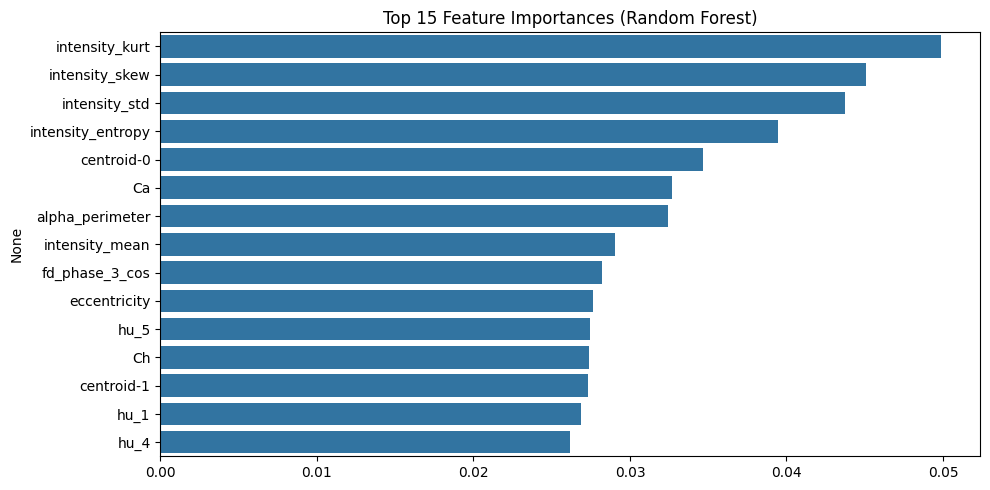

In [ ]:
# === 7. LightGBM ===
clf_lgbm = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm.fit(X_train, y_train)
y_pred_lgbm = clf_lgbm.predict(X_test)

print("\nLightGBM")
print(classification_report(y_test, y_pred_lgbm))

# With SMOTE
clf_lgbm_smote = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_smote.fit(X_train_smote, y_train_smote)
y_pred_lgbm_smote = clf_lgbm_smote.predict(X_test)

print("\nXGBoost with SMOTE")
print(classification_report(y_test, y_pred_xgb_smote))

# Undersampling
clf_lgbm_under = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_under.fit(X_train_under, y_train_under)
y_pred_lgbm_under = clf_lgbm_under.predict(X_test)

print("\nRandom Forest with Undersampling")
print(classification_report(y_test, y_pred_lgbm_under))


# === 8. Feature Importance Plot ===
importances = pd.Series(clf_rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


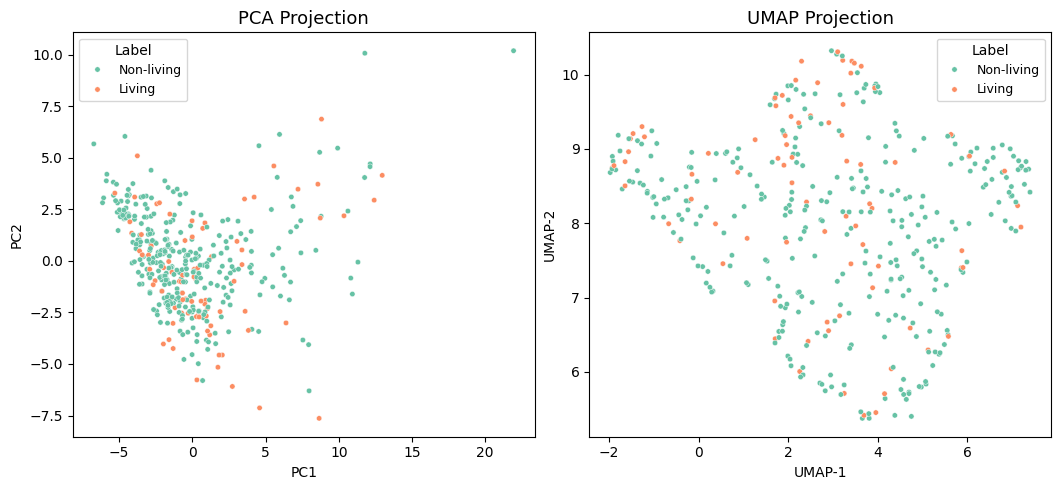

In [20]:
# === 9. PCA and UMAP Projections (Publication Quality) ===
label_names = np.where(y == 1, 'Living', 'Non-living')

# === PCA Projection ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# === UMAP Projection ===
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=label_names, palette='Set2', ax=axs[0], s=15)
axs[0].set_title("PCA Projection", fontsize=13)
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].legend(title="Label", fontsize=9, title_fontsize=10)

# UMAP
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=label_names, palette='Set2', ax=axs[1], s=15)
axs[1].set_title("UMAP Projection", fontsize=13)
axs[1].set_xlabel("UMAP-1")
axs[1].set_ylabel("UMAP-2")
axs[1].legend(title="Label", fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.savefig("pca_umap_projection.png", dpi=300, bbox_inches='tight')
plt.show()


In [27]:
def plot_roc_curve(clf, X_test, y_test, label="Model"):
    """
    Plot ROC curve for a binary classifier.

    Parameters:
    - clf: trained classifier with .predict_proba()
    - X_test: test features
    - y_test: true labels
    - label: label for the curve in the plot
    """
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    return fpr, tpr, roc_auc

/home/amtissot/miniconda3/envs/old_project_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


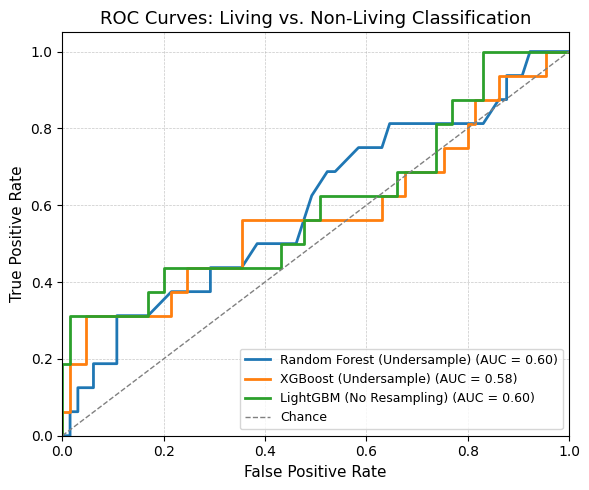

In [30]:
plt.figure(figsize=(6, 5))

# Curves
plot_roc_curve(clf_rf_under, X_test, y_test, label="Random Forest (Undersample)")
plot_roc_curve(clf_xgb_under, X_test, y_test, label="XGBoost (Undersample)")
plot_roc_curve(clf_lgbm, X_test, y_test, label="LightGBM (No Resampling)")

# Chance line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

# Axes labels and limits
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves: Living vs. Non-Living Classification', fontsize=13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Legend
plt.legend(loc='lower right', fontsize=9, frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("figures/roc_curves_classification.png", dpi=300, bbox_inches="tight")
plt.savefig("roc_curves_classification.png", dpi=300, bbox_inches='tight')
plt.show()
